In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
def save_notebook():
    return display(Javascript("IPython.notebook.save_notebook()"),
                   include=['application/javascript'])

def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [4]:
import sys, os
sys.path.append('../')

In [5]:
from rankutils.mappings import descriptor_map
from rankutils.cfgloader import cfgloader
from rankutils.evaluation import Evaluator
from rankutils.drawing import colors_from_cmap

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import mpld3

In [7]:
pathcfg = cfgloader("/home/alberto/phD/projects/performance_prediction/ret-mr-learning/source/path_2.cfg")
evalcfgfile = "/home/alberto/phD/projects/performance_prediction/ret-mr-learning/source/evalcfg/0005.compare_relabel.cfg"
barfigsize=(15, 8)
linefigsize=(8, 8)

In [8]:
def draw(evaluator, meas_key, method_key='set'):
    
    measure, idx, blim = evaluator.measure_map[meas_key]
    
    if method_key == 'set':
        mk = 'irp_evaluation'
    elif method_key == 'sample':
        mk = 'irp_evaluation_sample'
    else:
        raise ValueError("Invalid method key <{key:s}>. Choices are (\'set\', \'sample\')".format(method_key))

    fig, ax = plt.subplots()
    fig.set_size_inches(barfigsize)
    plt.tight_layout(pad=4.0)
    ax.set_title("Relevance Prediction\n{0:s}\n{1:s}".format(measure, key),
                 fontdict={'fontsize': 18, 'horizontalalignment': 'center'})

    # Enqueues the index of line plots to plot after plotting the bars
    line_queue = []

    data = evaluator.data
    xpos = 1
    
    handles = []
    labels = []

    for i, mdata in enumerate(data):

        val = mdata[mk][-1, idx]

        if mdata['params']['plot_type'] == 'bar':
            
            #print(mdata['name'], '->', mdata['drawargs']['color'])
            rect, = ax.bar(xpos, val, 0.9, 0, align='center', label=mdata['params']['label'] + "{0:1s}".format(''), 
                           color=mdata['drawargs']['color'], alpha=0.95)
            handles.append(rect)
            labels.append(mdata['params']['label'] + "{0:1s}".format(''))

            posx = rect.get_x()
            posy = rect.get_y()
            hgt = rect.get_height()
            wdt = rect.get_width()

            ax.text(posx + wdt/2, posy + hgt + 0.01, "{0:0.3f}".format(val), fontsize=12, bbox={'alpha': 0.0},
                     horizontalalignment='center')

            xpos += 1

        elif mdata['params']['plot_type'] == 'line':
            line_queue.append(i)

    rbound = xpos+3
    ax.set_xlim(left=0.0, right=rbound)

    # Lines are plotted after the xlimit is defined, which can only happen when all
    # bars are drawn
    for i in line_queue:

        mdata = data[i]
        val = mdata[mk][-1, idx]

        line, = ax.plot([0.0, rbound], [val, val], **mdata['drawargs'])
        handles.append(line)
        labels.append(mdata['params']['label'] + "{0:15s}".format(''))

        ax.text(0.02, val, "{0:0.3f}".format(val), fontsize=12, color=mdata['drawargs']['color'],
                horizontalalignment='left',  verticalalignment='bottom')

    ax.set_ylim(bottom=blim, top=1.1)
    ax.set_ylabel(meas_key)
    
    ax.set_xlabel('Method')
    ax.set_xticks([])

    # Rect Legend
    ax.legend(handles, labels, loc='lower right', bbox_to_anchor=[1.0, 0], fancybox=True, shadow=True)

In [9]:
def draw_pos_eval(evaluator):
    
    cmap = plt.get_cmap('Set1')
    
    measure, idx, blim = evaluator.measure_map['NACC']

    fig, ax = plt.subplots()
    fig.set_size_inches(linefigsize)
    plt.tight_layout(pad=4.0)
    ax.set_title("Positional Prediction\n{0:s}\n{1:s}".format(measure, key),
                 fontdict={'fontsize': 18, 'horizontalalignment': 'center'})


    data = evaluator.data
    
    handles = []
    labels = []
    
    for i, mdata in enumerate(data):

        y = mdata['pos_evaluation'][-1]
        x = np.arange(1, y.size+1).astype(np.int32)
        
        line, = ax.plot(x, y, fillstyle='full', alpha=0.9, **mdata['drawargs'])
        
        handles.append(line)
        labels.append(mdata['params']['label'])
        
    ax.set_ylim(bottom=0.0, top=1.0)
    ax.set_yticks([y for y in np.arange(0.0, 1.1, 0.1)])
    ax.set_yticklabels(["{0:0.1f}".format(y) for y in np.arange(0.0, 1.1, 0.1)], fontdict=dict(fontsize=12))
    ax.set_ylabel("nACC", fontdict=dict(fontsize=12))

    ax.set_xlim(left=1.0, right=10.0)
    ax.set_xticks([x for x in np.arange(1, 11, 1)])
    ax.set_xticklabels(["{0:d}".format(x) for x in np.arange(1, 11, 1)], fontdict=dict(fontsize=12))
    ax.set_xlabel("Rank Position", fontdict=dict(fontsize=12))


    # Line Legend
    plt.legend(handles, labels, fancybox=True, shadow=True)

    ax.grid(True, which='both')
    
    return

In [10]:
def draw_avg_bincount(evaluator):
    
    cmap = plt.get_cmap('Set1')
    
    measure, idx, blim = evaluator.measure_map['NACC']

    fig, ax = plt.subplots()
    fig.set_size_inches(linefigsize)
    plt.tight_layout(pad=4.0)
    ax.set_title("# of predictions per # of relevants\n{0:s}".format(key),
                 fontdict={'fontsize': 18, 'horizontalalignment': 'center'})
    
    ax.grid(True, which='both')


    data = evaluator.data
    
    handles = []
    labels = []
    
    ulim = -1
    
    for i, mdata in enumerate(data):

        y = mdata['predicted_counts'][-1]
        x = np.arange(0, y.size).astype(np.int32)
        
        if np.max(y) > ulim:
            ulim = np.max(y)
        
        line, = ax.plot(x, y, fillstyle='full', alpha=0.9, **mdata['drawargs'])
        
        handles.append(line)
        labels.append(mdata['params']['label'])
    
    ax.set_ylim(-0.5, ulim+0.5)
    ax.set_ylabel("Avg. # of predictions", fontdict=dict(fontsize=12))

    ax.set_xlim(left=-0.5, right=10.5)
    ax.set_xticks([x for x in np.arange(0, 11, 1)])
    ax.set_xticklabels(["{0:d}".format(x) for x in np.arange(0, 11, 1)], fontdict=dict(fontsize=12))
    ax.set_xlabel("# of relevants", fontdict=dict(fontsize=12))


    # Line Legend
    plt.legend(handles, labels, loc='upper center', bbox_to_anchor=[0.5, -0.08], fancybox=True, shadow=True)
    
    return

# Individual Relevance Prediction (IRP)
## Introduction

This document shows the normalized Accuracy (nACC) and Matthews Correlation Coefficient (MCC) results for individual releance prediction, or IRP. IRP refers to predicting the relevance of individual ranked positions of the rank, for example, predicting if the the 3rd ranked result for a certain query is relevant or not. IRP is performed for the first k ranked positions. In this specific scenario, k = 10.

## Method Labels

Next, each method label is described in order of appearance in each of the bar graphs. In parenthesis, are the prefixes used.

1. Baseline Methods (BASELINE)
   1. **PTOP10** : **Pseudo Top 10** : Every position in the $ top-k $, for $ k = 10 $, is marked as relevant.
   2. **P10-RAN** : **Random P@10** : Random positions in the $ top-k$, for $ k = 10 $, are marked as relevant. The proportion of relevant/non-relevant positions is the same as the $ P@10 $ obtained for the query analyzed.
2. Statistical Methods (STATISTICAL)
   1. **WBL-MR** : **Fixed Statistical - Weibull - Meta-Recognition** : Weibull-based statistical test for the $ top-k $ positions. A Weibull distribution is fitted to the tail of scores, established for positions $k+1$ and beyond of the rank, and used to find a cutting score $ T $, such that, every ranked position $ R_i $ with score greater than or equal to $ T $ is considered relevant, while every ranked position $ R_j $ with score less than $ T$ is considered non-relevant. A training stage is used to determine the limitant positions of the score tail to be fitted.
   2. **GEV-MR** : **Fixed Statistical - GEV - Meta-Recognition** : Generalized Extreme Value Distribution-based statistical test for the $ top-k $ positions. A GEV distribution is fitted to the tail of scores, established for positions $k+1$ and beyond of the rank, and used to find a cutting score $ T $, such that, every ranked position $ R_i $ with score greater than or equal to $ T $ is considered relevant, while every ranked position $ R_j $ with score less than $ T$ is considered non-relevant. A training stage is used to determine the limitant positions of the score tail to be fitted.
3. Learning Methods (LEARNING)
   1. **Score-based** (SCORE-BASED)
       1. **DELTAC** : **Circular Delta $i$ to $m$** : The feature vector for position $i$ is a sequence of $m-1$ values $<(s_i - s_1), (s_i - s_2), ..., (s_i - s_{i-1}), (s_i - s_{i+1}), ..., (s_i - s_m)>$, such that $s_i$ is the score at position $i$. This feature requires the _anchor_ position $i$ (which depends on the position we wish to predict), and  the final position $m$. For this experiment, $m = 20$ was used.
       2. **SDCT** : **Shift DCT coefficients from scores** : The feature vector for position $i$ is the $DCT$ transform of the first $j$ scores of the rank. For this experiment, $j = 10$ was used. Since $j$ is fixed, every position $i$ for $i \in {0, k}$ is the same.
   2. **Cluster-based** (CLUSTER-BASED)
       1. **DIFFC** : **Difference of $c$ tail clusters** : The feature vector for position $i$ is a sequence of $c$ values $<|(s_i - M_1)|, |(s_i - M_2)|, ..., |(s_i - M_c)|>$, such that $s_i$ is the score at position $i$, and $\left \{ M_1, M2, ..., M_c \right \}$ are the $c$ cluster centers found by clusterizing the scores from position $k+1$ and beyond. For this experiment, $c = 64$ was used, and the clustering method was [Jenks Natural Breaks Optmization](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization).
   3. **Statistical-based** (STATISTICAL-BASED)
       1. **GEV-EMD** : **Earth movers distance between top-k GEV tail distribution fits **
       2. **WBL-EMD** : **Earth movers distance between top-k WBL tail distribution fits **
       3. **GEV-Query-BHATT** : **Battacharyya coefficients between query tail GEV fit and rank i tail GEV fit **
   4. **Fusion of descriptors** (FUSION)
       1. **EFH** : Combination of _3.A.a_ , _3.A.b_ , and _3.C.a_ by concatenating them
       2. **EFGH** : Combination of _3.A.a_ , _3.A.b_ , _3.B.a_, and _3.C.a_ by concatenating them
   
When not specified, all learning methods employed the [Random Forest Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) of lib [scikit-learn](scikit-learn.org). 

## Evaluation Measures

* $TP$: True Positives
* $FP$: False Positives
* $TN$: True Negatives
* $FN$: False Negatives

##### nACC: Normalized Accuracy

$nACC = \frac{\frac{TP}{TP + FN} + \frac{TN}{TN + FP} }{2}$<br>
<br>
The function is computed as $nACC(groundtruth, predicted)$

##### MCC: Matthews Correlation Coefficient

$MCC = \frac{(TP \times TN) - (FP \times FN)}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}$<br>
<br>
The function is computed as $MCC(groundtruth, predicted)$

## Evaluation Methodologies
Consider the following relevance prediction example, with five samples, each predicting top-3 positions of the rank:

| Samples 	|       	| Pred. 	|       	|   	|       	|   GT  	|       	|
|---------	|:-----:	|:-----:	|:-----:	|:-:	|:-----:	|:-----:	|:-----:	|
|         	| Pos 1 	| Pos 2 	| Pos 3 	|   	| Pos 1 	| Pos 2 	| Pos 3 	|
| A       	|   1   	|   1   	|   1   	|   	|   1   	|   0   	|   1   	|
| B       	|   1   	|   0   	|   0   	|   	|   0   	|   0   	|   0   	|
| C       	|   1   	|   1   	|   0   	|   	|   1   	|   1   	|   0   	|
| D       	|   1   	|   1   	|   0   	|   	|   1   	|   1   	|   1   	|
| E       	|   0   	|   0   	|   0   	|   	|   0   	|   0   	|   1   	|

### 1. Per set nACC Evaluation
For each set of predictions, performs a single evaluation by measuring the $nACC$ between the a vector of concatenated. For the aforementioned example the $nACC$ computed would be:<br>
<p align="center">
$nACC(\{1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1\}, \{1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0\}) = 0.732$
</p>

### 2. Avg. of per sample nACC Evaluation
For each set of predictions, computes the average between the nACC for each sample. For the aforementioned example, this value would be computed as:<br>
<p align="center">
$Average(nACC(\{1, 0, 1\}, \{1, 1, 1\}),~ nACC(\{0, 0, 0\}, \{1, 0, 0\}),~ nACC(\{1, 1, 0\}, \{1, 1, 0\}),~ nACC(\{1, 1, 1\}, \{1, 1, 0\}),~ nACC(\{0, 0, 1\}, \{0, 0, 0\})) = Average(0.50, 0.33, 1.0, 0.33, 0.5) = 0.532$
</p>

### 3. Per set MCC evaluation
For each set of predictions, performs a single evaluation by measuring the $MCC$ between the a vector of concatenated. For the aforementioned example the $MCC$ computed would be:<br>
<p align="center">
$MCC(\{1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1\}, \{1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0\}) = 0.464$
</p>

### 4. Positional nACC evaluation
For each set of predictions, we concatenate all predictions for position $i$, with $i \in \{1, 2,...,k\}$, and measure the $nACC$ between it and the groundtruth relevances. The results are depicted as a plot in which the x-axis are the values between $1$ and $k$, and the y-axis their corresponding $nACC$. For the aforementioned example, in which $k=3$, there would be the following measurements:<br>
<p align="center">
Position 1: $nACC(\{1, 0, 1, 1, 0\}, \{1, 1, 1, 1, 0\}) = 0.750$
</p>
<p align="center">
Position 2: $nACC(\{0, 0, 1, 1, 0\}, \{1, 0, 1, 1, 0\}) = 0.833$
</p>
<p align="center">
Position 3: $nACC(\{1, 0, 0, 1, 1\}, \{1, 0, 0, 0, 0\}) = 0.666$
</p>

### 5. Number of predictions with $n$ relevants
For each set of predictions, the number of predictions with $n$ relevants, such that $n \in \{0, 1, 2, ..., k\}$, is counted and plotted. For the aforementioned example, we have:
<p align="center">
$0$ relevants: $1$ prediction (prediction $E$)
</p>
<p align="center">
$1$ relevant: $1$ prediction (prediction $B$)
</p>
<p align="center">
$2$ relevants: $2$ predictions (predictions $C$ and $D$)
</p>
<p align="center">
$3$ relevants: $1$ prediction (prediction $A$)
</p>

***
# Places365 - Descriptor 1 (vgg16 DEEPFV)
***

In [11]:
key = "places365_desc1"
evtor = Evaluator(evalcfgfile=evalcfgfile, key=key, pathcfg=pathcfg)
evtor.evaluate()

### Per set nACC evaluation
[Definition](#1.-Per-set-nACC-Evaluation)

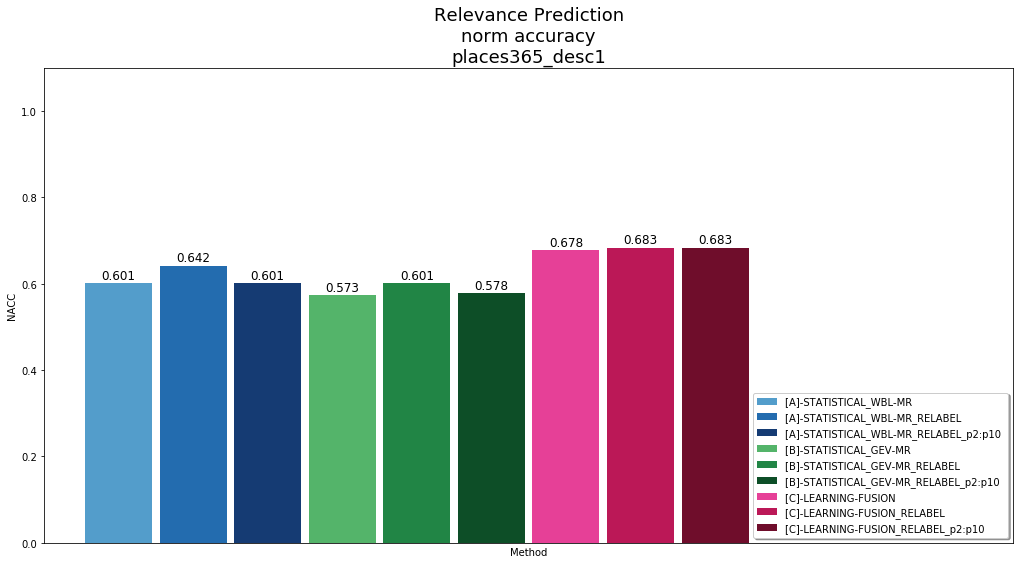

In [12]:
draw(evtor, 'NACC')
#mpld3.enable_notebook()

### Per set MCC evaluation
[Definition](#3.-Per-set-MCC-evaluation)

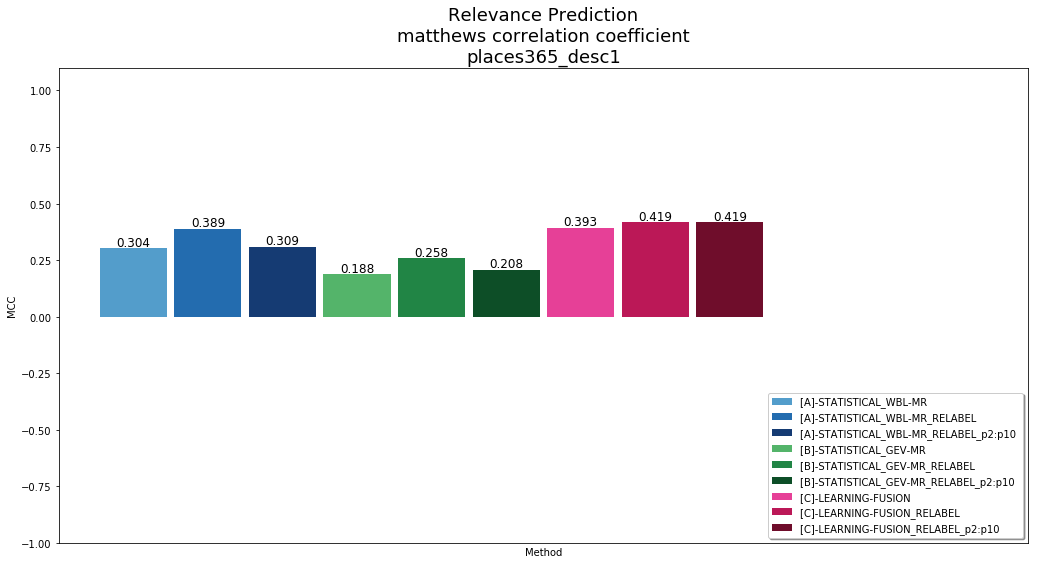

In [13]:
draw(evtor, 'MCC')
#mpld3.enable_notebook()

### Positional nACC evaluation
[Definition](#4.-Positional-nACC-evaluation)

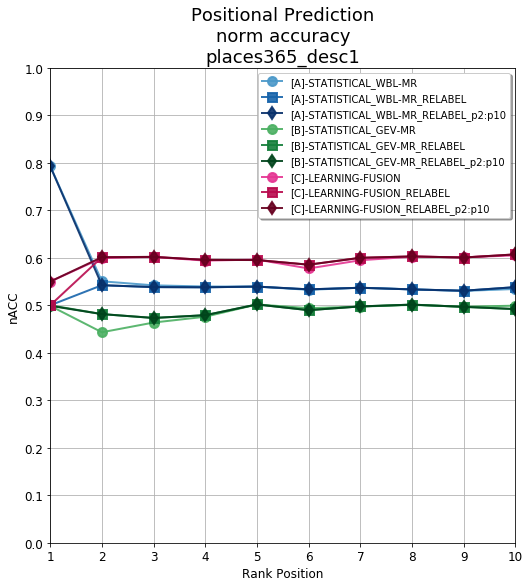

In [14]:
draw_pos_eval(evtor)

### Number of predictions with $n$ relevants
[Definition](#5.-Number-of-predictions-with-$n$-relevants)

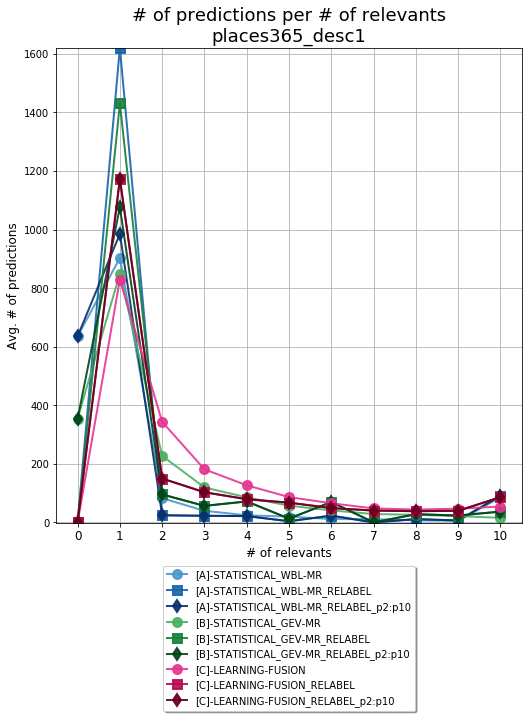

In [15]:
draw_avg_bincount(evtor)

***
# Places365 - Descriptor 2 (resnet152 DEEPFV)
***

In [16]:
key = "places365_desc2"
evtor = Evaluator(evalcfgfile=evalcfgfile, key=key, pathcfg=pathcfg)
evtor.evaluate()

### Per set nACC evaluation
[Definition](#1.-Per-set-nACC-Evaluation)

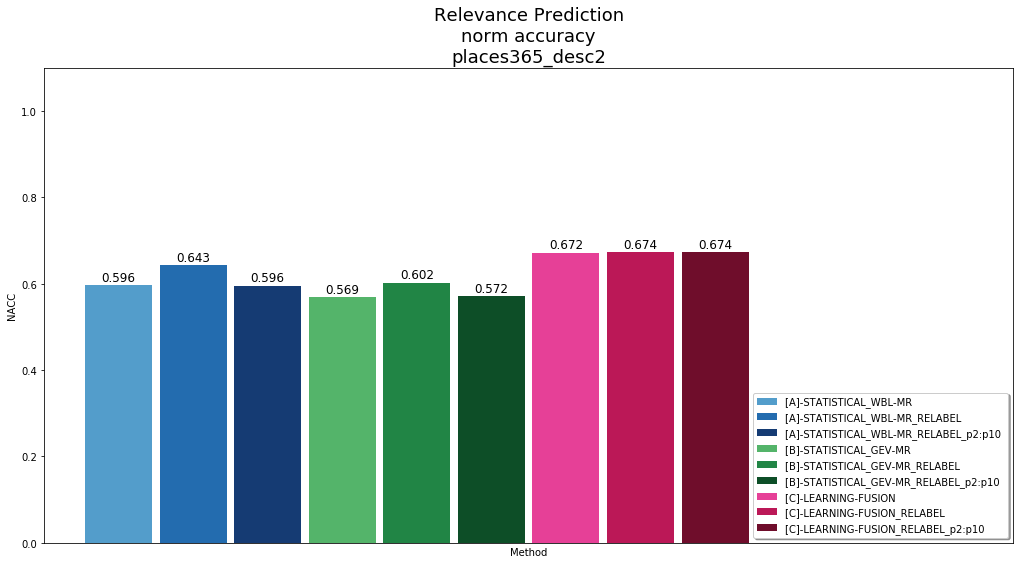

In [17]:
draw(evtor, 'NACC')
#mpld3.enable_notebook()

### Per set MCC evaluation
[Definition](#3.-Per-set-MCC-evaluation)

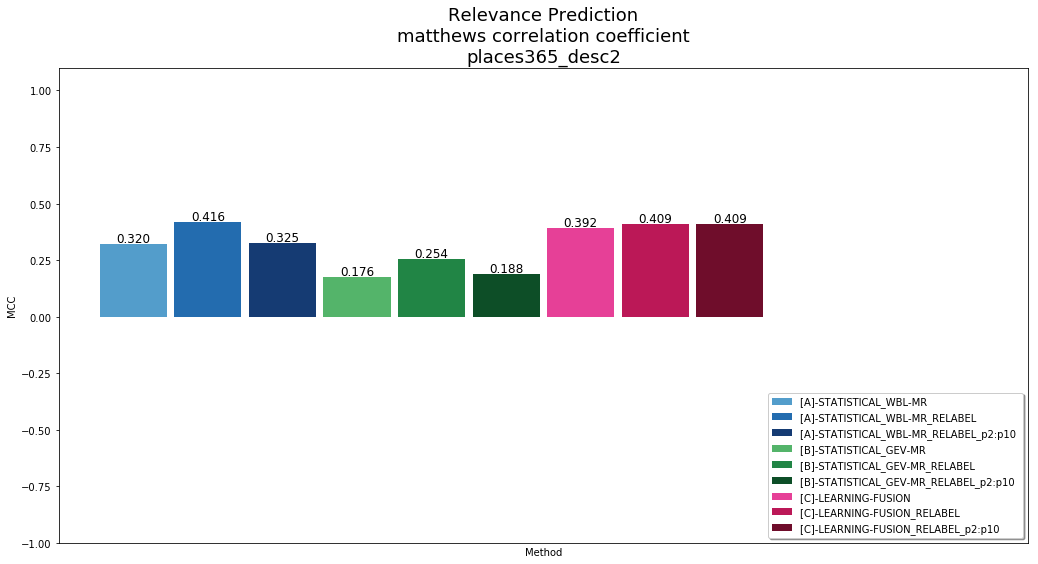

In [18]:
draw(evtor, 'MCC')
#mpld3.enable_notebook()

### Positional nACC evaluation
[Definition](#4.-Positional-nACC-evaluation)

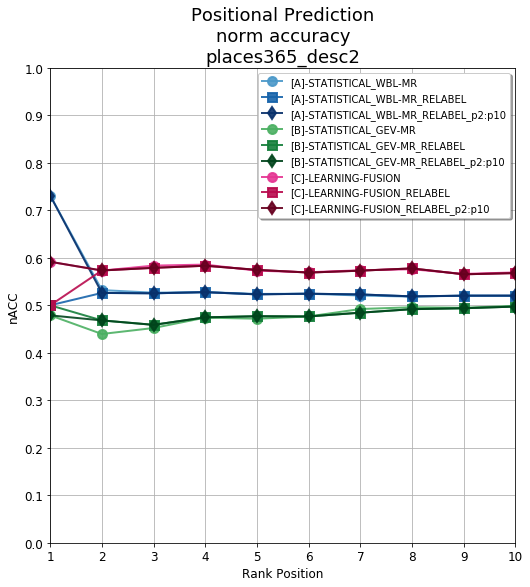

In [19]:
draw_pos_eval(evtor)

### Number of predictions with $n$ relevants
[Definition](#5.-Number-of-predictions-with-$n$-relevants)

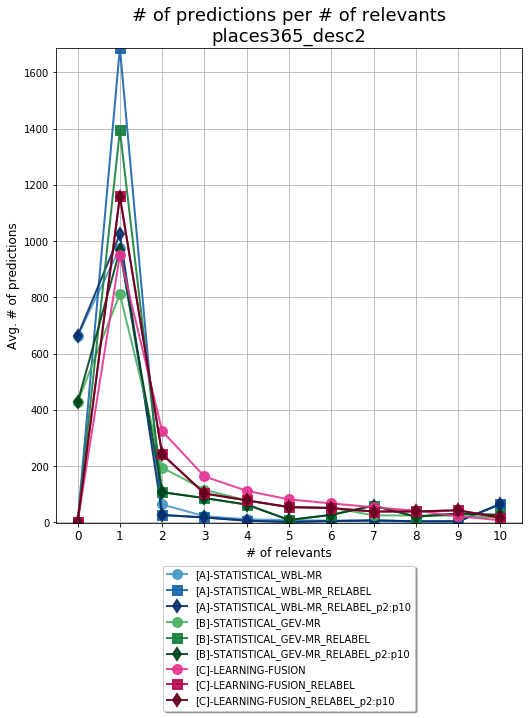

In [20]:
draw_avg_bincount(evtor)

***
# VGGFaces - Descriptor 1 (DEEPFV)
***

In [21]:
key = "vggfaces_desc1"
evtor = Evaluator(evalcfgfile=evalcfgfile, key=key, pathcfg=pathcfg)
evtor.evaluate()

### Per set nACC evaluation
[Definition](#1.-Per-set-nACC-Evaluation)

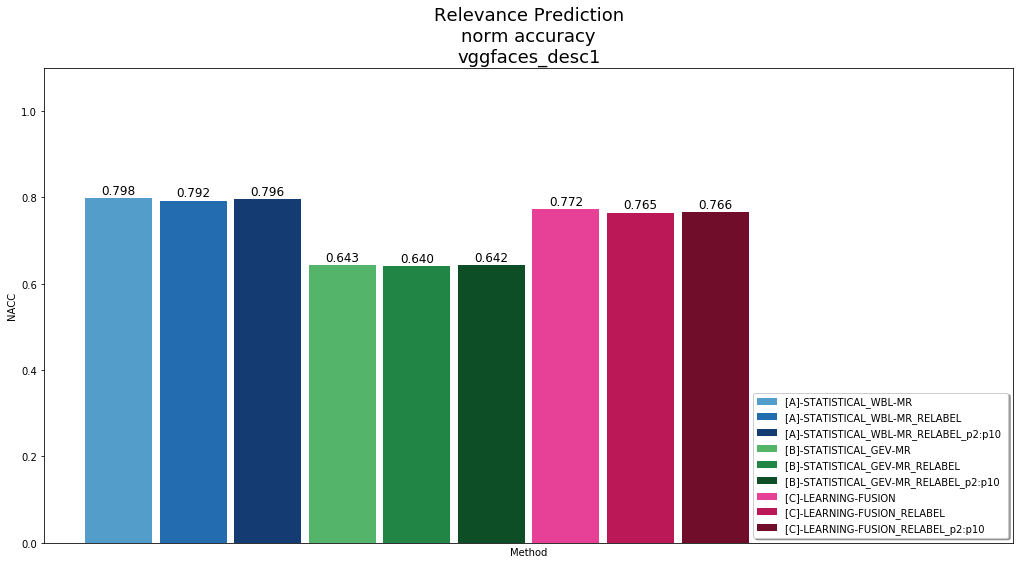

In [22]:
draw(evtor, 'NACC')
#mpld3.enable_notebook()

### Per set MCC evaluation
[Definition](#3.-Per-set-MCC-evaluation)

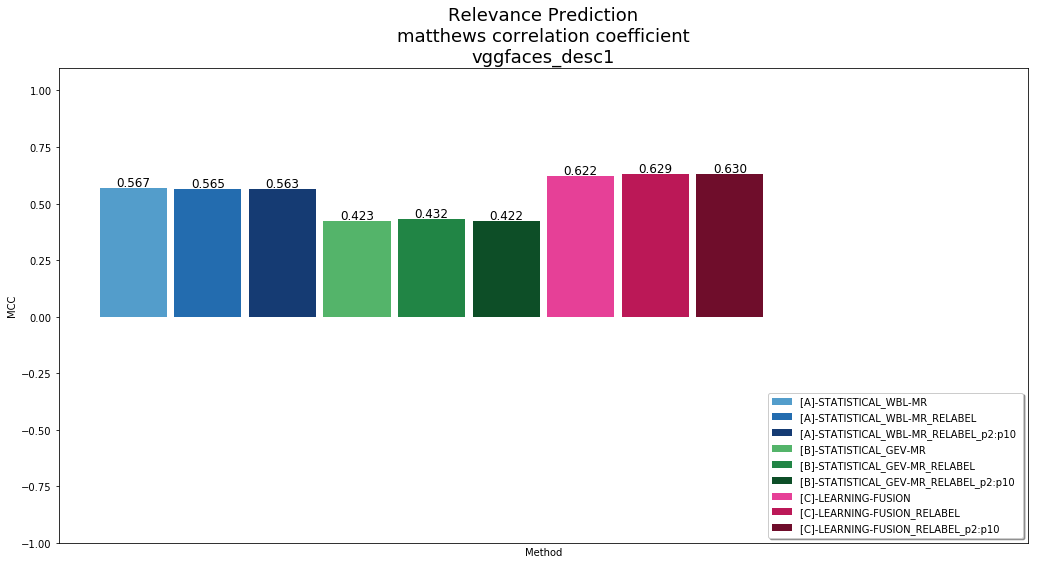

In [23]:
draw(evtor, 'MCC')
#mpld3.enable_notebook()

### Positional nACC evaluation
[Definition](#4.-Positional-nACC-evaluation)

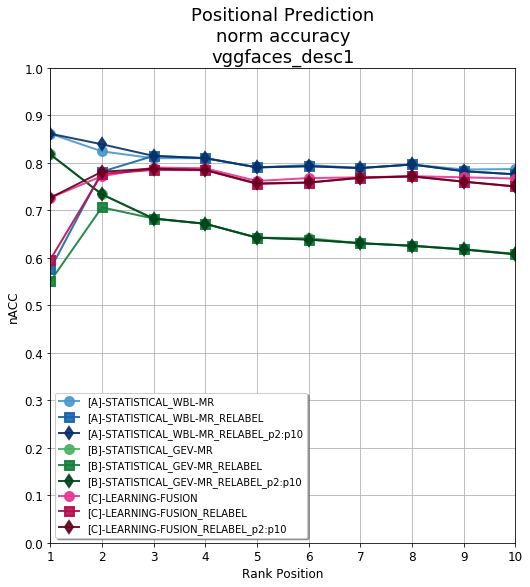

In [24]:
draw_pos_eval(evtor)

### Number of predictions with $n$ relevants
[Definition](#5.-Number-of-predictions-with-$n$-relevants)

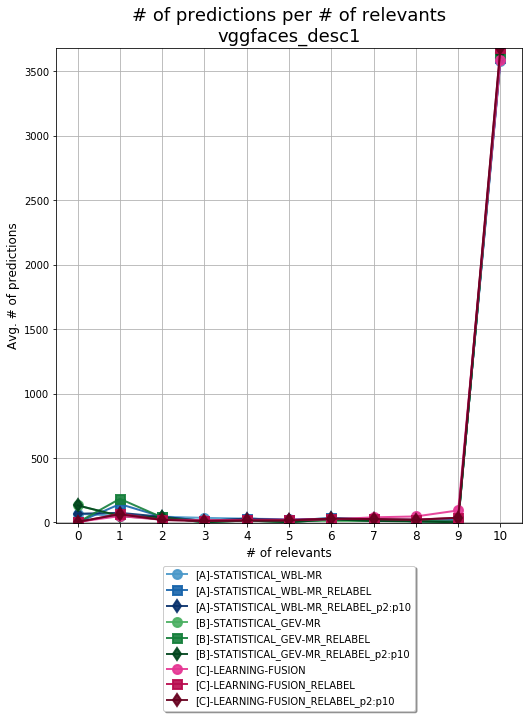

In [25]:
draw_avg_bincount(evtor)

***
# VGGFaces - Descriptor 2 (DEEPFV + Perturbations)
***

In [26]:
key = "vggfaces_desc2"
evtor = Evaluator(evalcfgfile=evalcfgfile, key=key, pathcfg=pathcfg)
evtor.evaluate()

### Per set nACC evaluation
[Definition](#1.-Per-set-nACC-Evaluation)

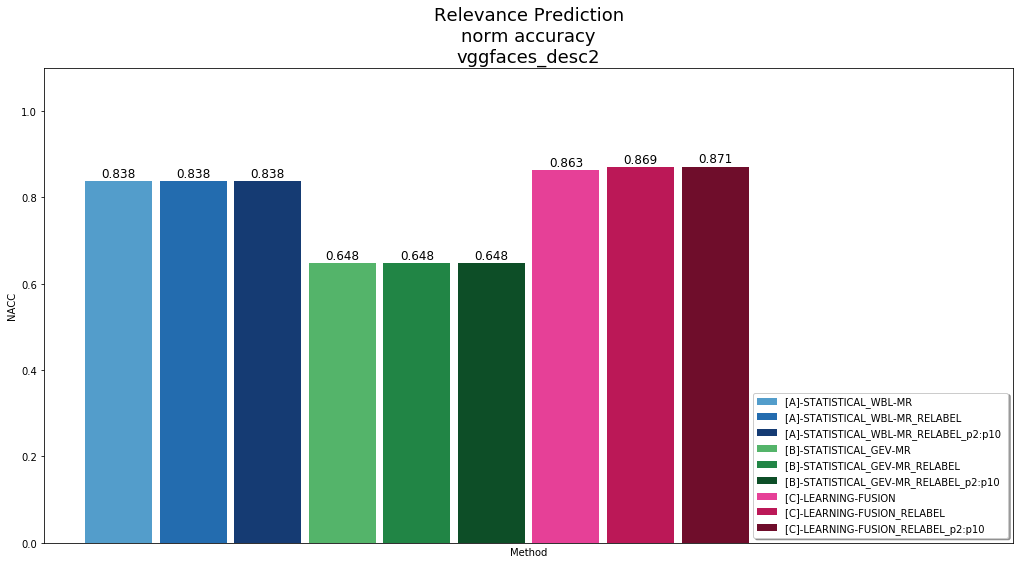

In [27]:
draw(evtor, 'NACC')
#mpld3.enable_notebook()

### Per set MCC evaluation
[Definition](#3.-Per-set-MCC-evaluation)

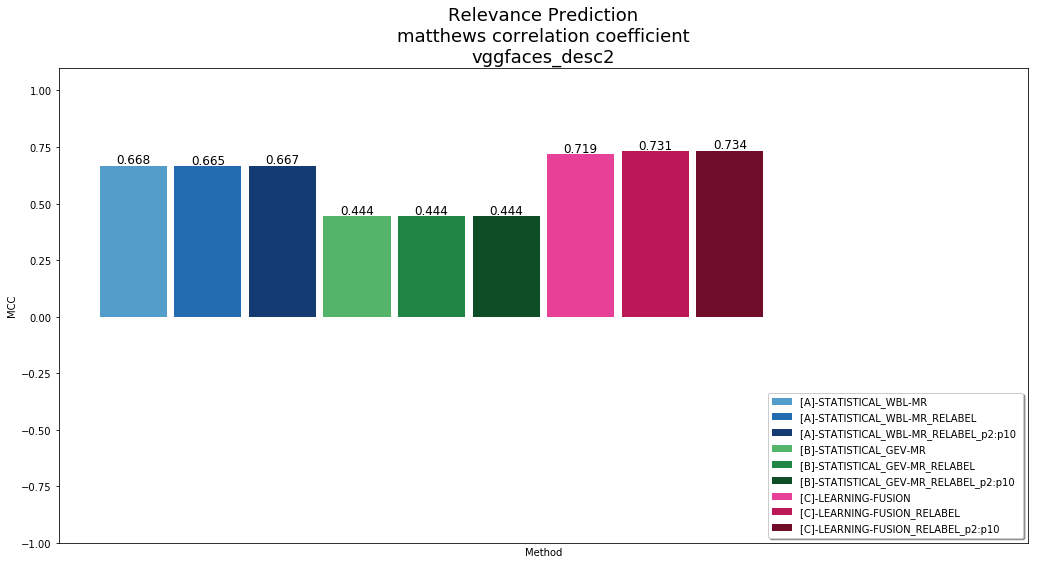

In [28]:
draw(evtor, 'MCC')
#mpld3.enable_notebook()

### Positional nACC evaluation
[Definition](#4.-Positional-nACC-evaluation)

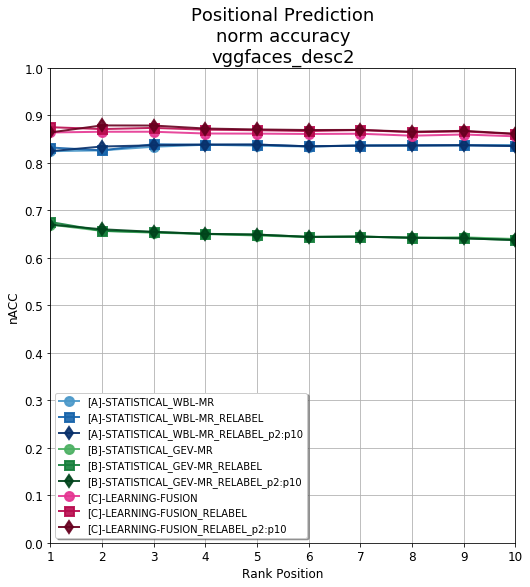

In [29]:
draw_pos_eval(evtor)

### Number of predictions with $n$ relevants
[Definition](#5.-Number-of-predictions-with-$n$-relevants)

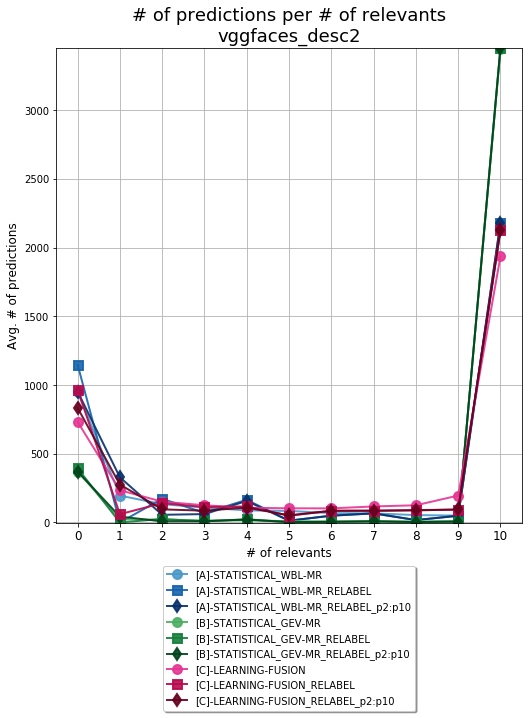

In [30]:
draw_avg_bincount(evtor)

***
# Imagenet - Descriptor 1 (resnetV2)
***

In [31]:
key = "imagenet_desc1"
evtor = Evaluator(evalcfgfile=evalcfgfile, key=key, pathcfg=pathcfg)
evtor.evaluate()

/home/alberto/miniconda3/envs/albpy/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


### Per set nACC evaluation
[Definition](#1.-Per-set-nACC-Evaluation)

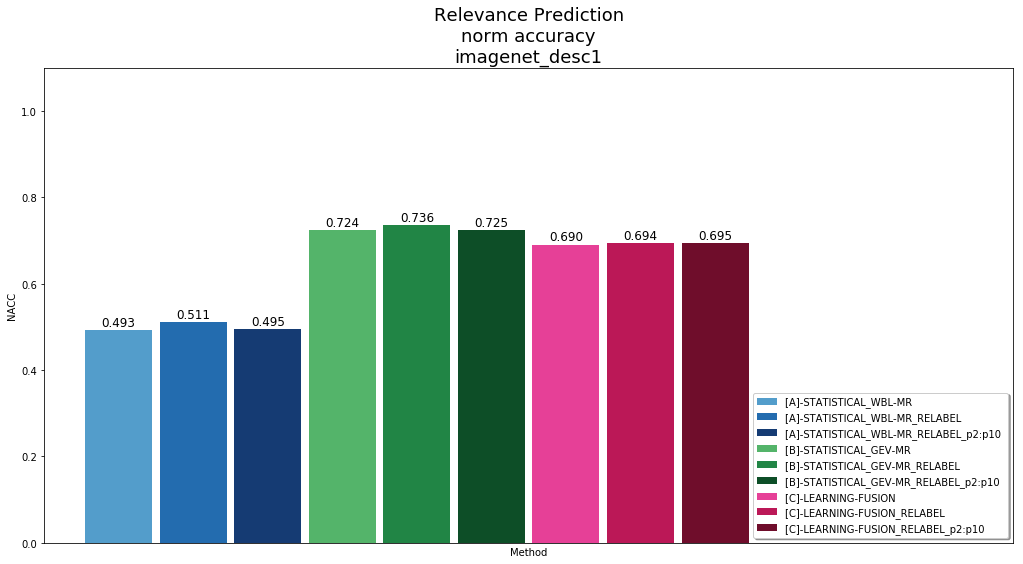

In [32]:
draw(evtor, 'NACC')
#mpld3.enable_notebook()

### Per set MCC evaluation
[Definition](#3.-Per-set-MCC-evaluation)

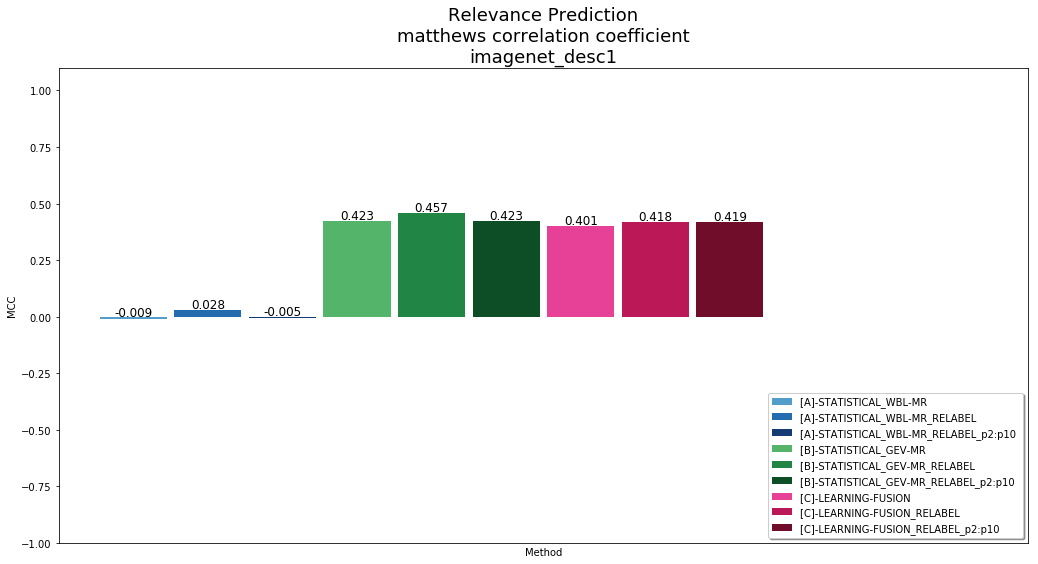

In [33]:
draw(evtor, 'MCC')
#mpld3.enable_notebook()

#from subprocess import call
#out = call(['ipython','nbconvert', 'irp_evaluation.ipynb'])

### Positional nACC evaluation
[Definition](#4.-Positional-nACC-evaluation)

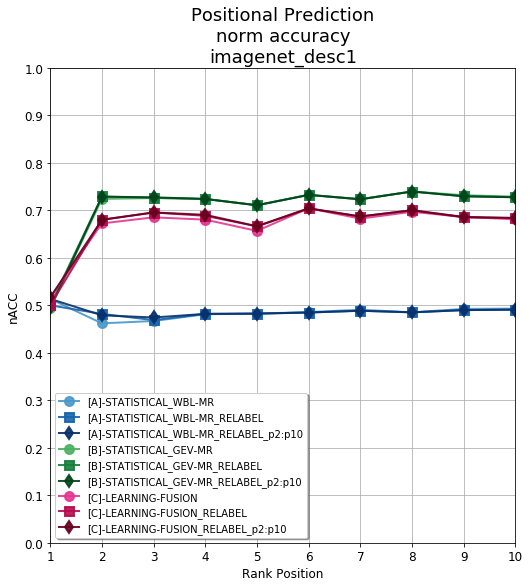

In [34]:
draw_pos_eval(evtor)

### Number of predictions with $n$ relevants
[Definition](#5.-Number-of-predictions-with-$n$-relevants)

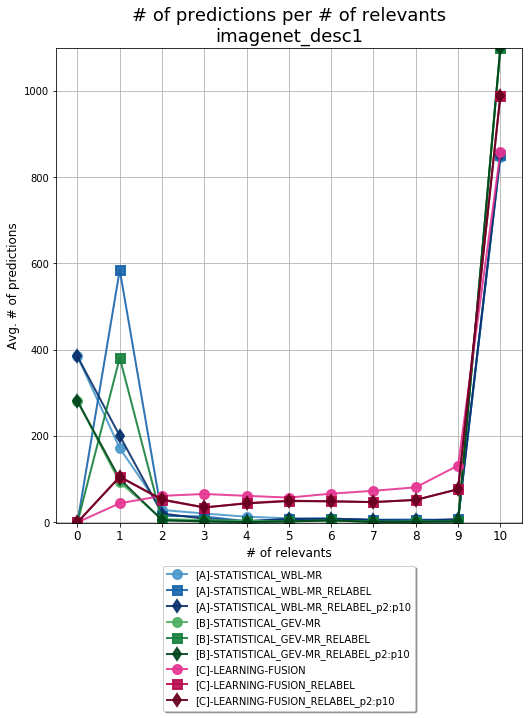

In [35]:
draw_avg_bincount(evtor)